In [1]:
!pip -V

pip 23.3.1 from /root/feature-map-experiments/.cenv/lib/python3.10/site-packages/pip (python 3.10)


In [2]:
!pip list | grep clip

clip                      1.0


In [3]:
!pip list | grep opencv
!pip list | grep scikit-learn

opencv-python             4.10.0.84
scikit-learn              1.5.1


In [4]:
# !pip install git+https://github.com/mhamilton723/FeatUp.git
# !pip install pip install git+https://github.com/openai/CLIP.git

# .init

In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [6]:
import os
import sys
from pathlib import Path
workspace_dir = Path.cwd()
if not (workspace_dir / '.git').exists():
    workspace_dir = workspace_dir.parent


module_path = str(workspace_dir.resolve()) # os.path.abspath(os.path.join('..'))
print(f'workspace dir: {module_path}')

# Fixes a periodic issue with locating local packages.
if module_path not in sys.path:
    sys.path.append(module_path)

workspace dir: /root/feature-map-experiments


In [7]:
import torch
import torchvision.transforms as T
from PIL import Image

from featup.util import norm, unnorm
from featup.plotting import plot_feats, plot_lang_heatmaps

## Dino v2 upsampler

In [8]:
import matplotlib.pyplot as plt
from featup.util import pca, remove_axes
from pytorch_lightning import seed_everything

from fmc.plot_utils import plot_feats_pca, display_image_grid, display_image_grid_gs

In [9]:
from fmc.segmenter import init_upsampler, transform, mass_upsample

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
upsampler = init_upsampler(device=device)


Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
/root/feature-map-experiments/.cenv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/feature-map-experiments/.cenv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/feature-map-experiments/.cenv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/h

## Patch utils

In [10]:
from fmc.patches_utils import extract_patch, extract_patches_numpy, extract_patches_pillow_matrix, extract_patches_pillow


# Image conf

In [11]:
patch_size = int(224/2)
overlap = 0
# patch_size = int(256/2)
# overlap = int(26/2)

step = patch_size - overlap
output_overlap = int(256 * overlap / patch_size)

print(f'{patch_size=} {overlap=} {step=} {output_overlap=}')



patch_size=112 overlap=0 step=112 output_overlap=0


## Load images

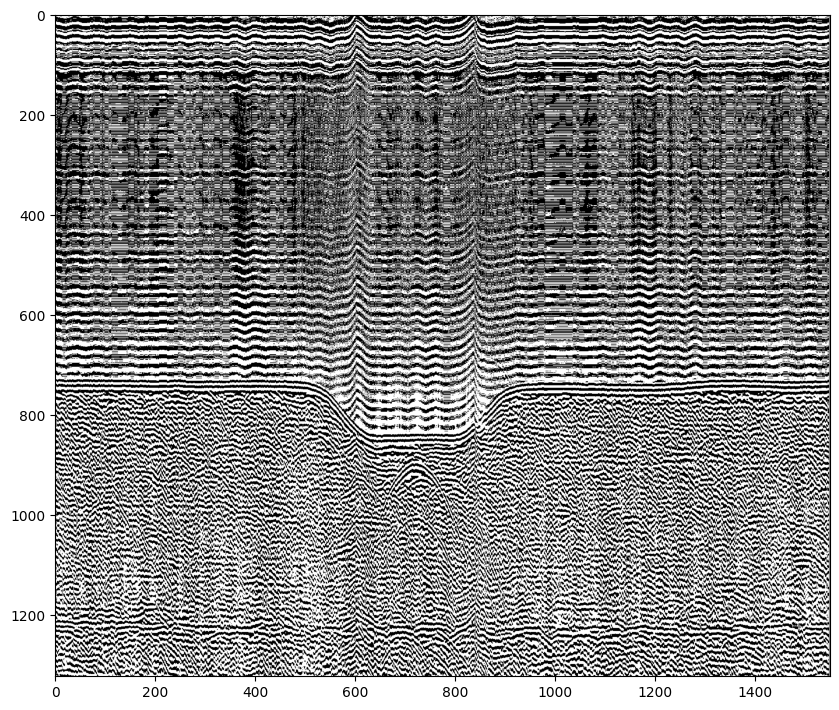

In [59]:
# image_path = '/root/feature-map-experiments/assets/c16-part1.png'
# image_path = '/root/feature-map-experiments/assets/c17-part1.png'
# image_path = '/root/feature-map-experiments/assets/UT_cytopathology_213_239_roi_7333.jpeg'
# image_path = '../assets/DJI_1065.png'
# image_path = '/root/feature-map-experiments/assets/0297_Exposed Pipe.png'
image_path = '/root/feature-map-experiments/assets/0334_Buried Pipe.png'

image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [60]:
patches_mat = extract_patches_pillow_matrix(image, patch_size=(patch_size, patch_size), step=(step,step))
patches_mat.shape

(11, 13, 112, 112, 3)

# Draw Patches Grid

In [61]:
print(f'{patches_mat.shape[0:2]=}')

patches_mat_shape = patches_mat.shape[0:2]
flat_patches_mat = patches_mat.reshape(-1, *patches_mat.shape[2:])

patches_mat.shape[0:2]=(11, 13)


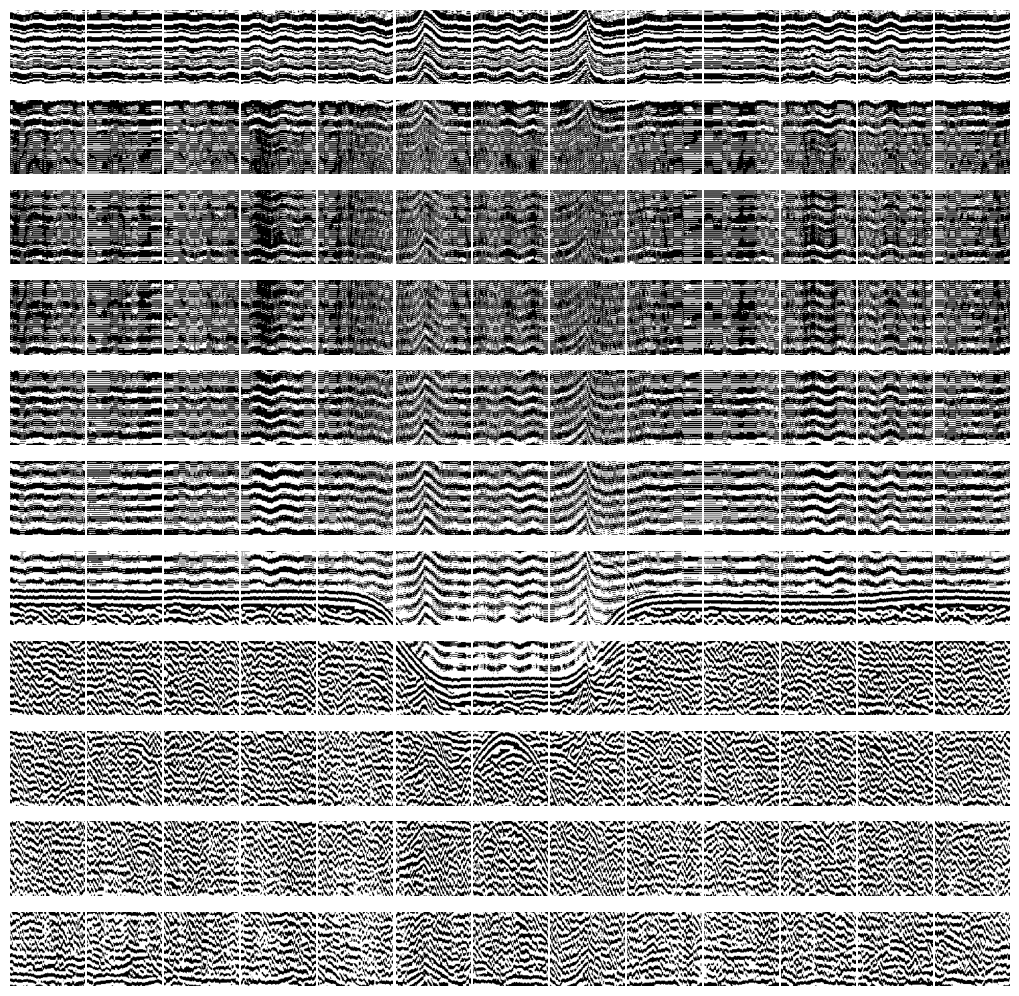

In [62]:
display_image_grid(flat_patches_mat, patches_mat_shape)

In [63]:
flat_patches_mat.shape

(143, 112, 112, 3)

In [64]:
import multiprocessing

multiprocessing.cpu_count()

80

# Calculate significant patch indexes

In [65]:
from fmc.image_utils import detect_blank_patch
threshold = 10.
significant_patch_indexes = []
for i, patch in enumerate(flat_patches_mat):
    mean, std_dev, is_blank = detect_blank_patch(patch, threshold=threshold)
    if is_blank:
        print(f'excluded {i}: {mean=} {std_dev=}')
    else:
        significant_patch_indexes.append(i)


# Process using upsampler

## Just pre-experiments

In [66]:
# image_tensor = transform(Image.fromarray(flat_patches_mat[4])).unsqueeze(0).to(device)

In [67]:

# hr_feats = upsampler(image_tensor)
# lr_feats = upsampler.model(image_tensor)
# fit_pca = plot_feats_pca(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

In [68]:
# print(f'{hr_feats.shape=} {lr_feats.shape=}')

## Mass processing

In [69]:
lr_feats_list, hr_feats_list = mass_upsample(upsampler, flat_patches_mat, device=device)

image_tensors.shape=torch.Size([143, 3, 224, 224])
lr_feats_list.shape=torch.Size([143, 384, 16, 16])  hr_feats_list.shape=torch.Size([143, 384, 256, 256])


In [70]:
# fit_pca = None
# unn_image_tensors = unnorm(image_tensors)
# for i in range(3):
#     fit_pca = plot_feats_pca(unn_image_tensors[i], lr_feats[i], hr_feats[i], fit_pca = fit_pca)

# Select meaningful patches

In [71]:
lr_feats_list.shape

torch.Size([143, 384, 16, 16])

In [72]:
s_lr_feats_list = lr_feats_list[significant_patch_indexes] 
s_hr_feats_list = hr_feats_list[significant_patch_indexes]

## PCA on image features

In [73]:
hr_feats_list[4].shape

torch.Size([384, 256, 256])

Seed set to 0


hr_feats_pca.shape=torch.Size([143, 3, 256, 256])


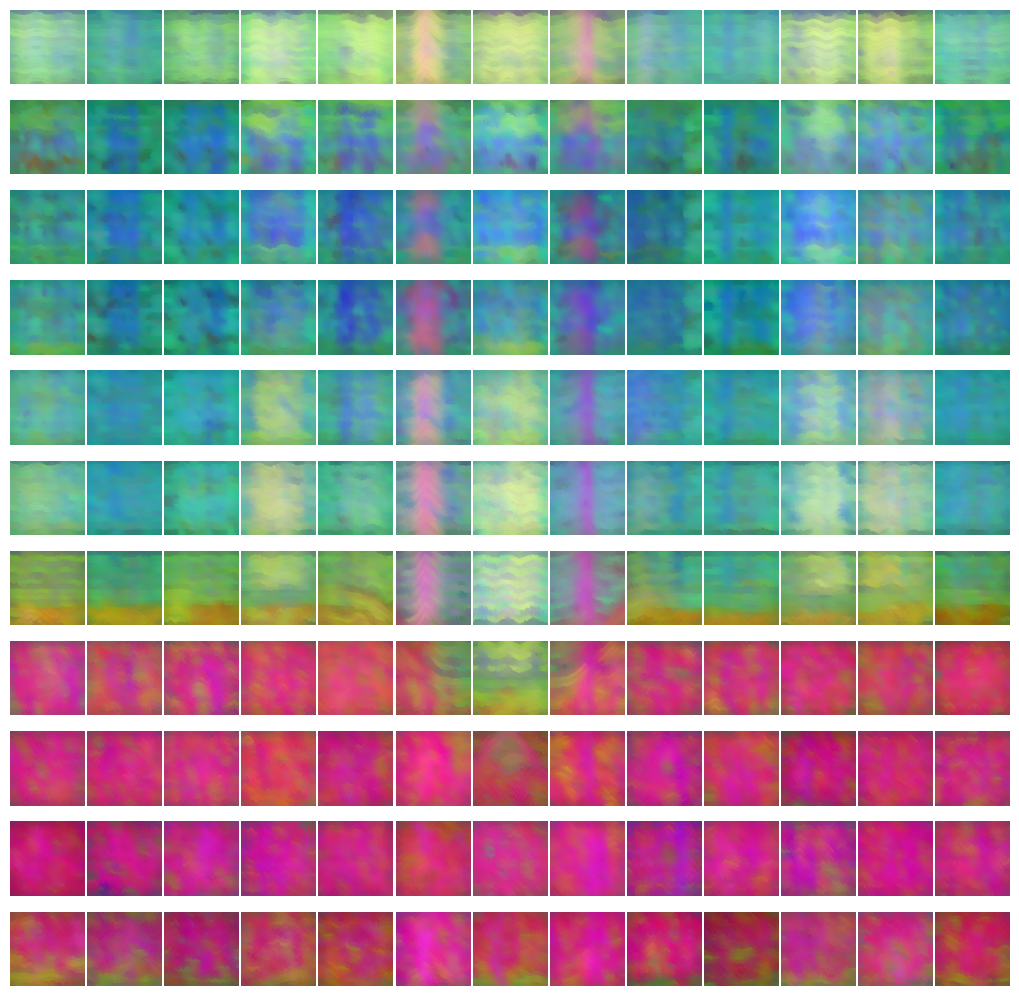

In [74]:
import pickle 

seed_everything(0)
fit_pca = None
use_meaning_strategy = 'exist'
if use_meaning_strategy == 'single_patch':
    _, fit_pca = pca([hr_feats_list[4].unsqueeze(0), lr_feats_list[4].unsqueeze(0)], fit_pca=fit_pca)
elif use_meaning_strategy == 'significant':
    _, fit_pca = pca([s_hr_feats_list, s_lr_feats_list], fit_pca=fit_pca)
elif use_meaning_strategy == 'exist':
    with open("pca_model.pkl", "rb") as f:
        fit_pca = pickle.load(f)


[hr_feats_pca, lr_feats_pca], fit_pca = pca([hr_feats_list, lr_feats_list], fit_pca=fit_pca)
# [hr_feats_pca, _], fit_pca = pca([hr_feats_list, hr_feats_list], fit_pca=None)
print(f'{hr_feats_pca.shape=}')


hr_feats_pca_arr = [p.permute(1, 2, 0).detach().cpu() for p in hr_feats_pca]

display_image_grid(hr_feats_pca_arr, patches_mat_shape)

In [75]:
fit_pca

In [76]:
len(hr_feats_pca_arr)

143

In [77]:
import numpy as np
hr_feats_pca_flat = np.stack(hr_feats_pca_arr)
hr_feats_pca_flat.shape

(143, 256, 256, 3)

In [78]:
hr_feats_mat = hr_feats_pca_flat.reshape(
    patches_mat_shape[0], patches_mat_shape[1], *hr_feats_pca_flat.shape[1:])

hr_feats_mat.shape

(11, 13, 256, 256, 3)

## UMAP on image features

In [81]:
hr_feats_list.detach().cpu().numpy().shape

(169, 384, 256, 256)

In [45]:
import numpy as np
from fmc.segmenter import umap_fl


fit_umap = None
use_meaning_center = True
if use_meaning_center:
    _, fit_umap = umap_fl([lr_feats_list[4].unsqueeze(0), hr_feats_list[4].unsqueeze(0)], fit_umap=fit_umap)

print(f'{fit_umap=}')
[lr_feats_umap, hr_feats_umap], fit_umap = umap_fl([lr_feats_list, hr_feats_list], fit_umap=fit_umap)
# [hr_feats_pca, _], fit_pca = pca([hr_feats_list, hr_feats_list], fit_pca=None)

# ax[2].imshow(hr_feats_pca[0].permute(1, 2, 0).detach().cpu())
hr_feats_umap_arr = [p.permute(1, 2, 0).detach().cpu() for p in hr_feats_umap]

display_image_grid(hr_feats_umap_arr, patches_mat_shape)

umap fit: x.shape=torch.Size([512, 384])
len(x_red)=256
CUDA call='cudaEventDestroy(event_)' at file=/__w/cuml/cuml/python/cuml/build/cp310-cp310-linux_x86_64/_deps/raft-src/cpp/include/raft/core/resource/cuda_event.hpp line=34 failed with an illegal memory access was encountered


RuntimeError: CUDA error encountered at: file=/__w/raft/raft/cpp/include/raft/core/interruptible.hpp line=303: call='query_result', Reason=cudaErrorIllegalAddress:an illegal memory access was encountered
Obtained 63 stack frames
#1 in /root/feature-map-experiments/.cenv/lib/python3.10/site-packages/pylibraft/common/handle.cpython-310-x86_64-linux-gnu.so: raft::cuda_error::cuda_error(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&) +0x5a [0x7f3e0b3509da]
#2 in /root/feature-map-experiments/.cenv/lib/python3.10/site-packages/pylibraft/common/handle.cpython-310-x86_64-linux-gnu.so: void raft::interruptible::synchronize_impl<cudaError (*)(CUstream_st*), rmm::cuda_stream_view>(cudaError (*)(CUstream_st*), rmm::cuda_stream_view) +0x1d5 [0x7f3e0b35ab65]
#3 in /root/feature-map-experiments/.cenv/lib/python3.10/site-packages/pylibraft/common/handle.cpython-310-x86_64-linux-gnu.so(+0x433fa) [0x7f3e0b34a3fa]
#4 in /root/feature-map-experiments/.cenv/lib/python3.10/site-packages/cuml/manifold/umap.cpython-310-x86_64-linux-gnu.so(+0x3aa75) [0x7f3e09d0ea75]
#5 in /root/feature-map-experiments/.cenv/lib/python3.10/site-packages/cuml/internals/base.cpython-310-x86_64-linux-gnu.so(+0x1006e) [0x7f3e1e68f06e]
#6 in /root/feature-map-experiments/.cenv/lib/python3.10/site-packages/cuml/internals/base.cpython-310-x86_64-linux-gnu.so(+0x2e7a6) [0x7f3e1e6ad7a6]
#7 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x2b79 [0x4efb19]
#8 in /root/feature-map-experiments/.cenv/bin/python() [0x508006]
#9 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x2b79 [0x4efb19]
#10 in /root/feature-map-experiments/.cenv/bin/python: _PyFunction_Vectorcall +0x6f [0x4fcadf]
#11 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x2b79 [0x4efb19]
#12 in /root/feature-map-experiments/.cenv/bin/python() [0x507eae]
#13 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x4b26 [0x4f1ac6]
#14 in /root/feature-map-experiments/.cenv/bin/python: _PyFunction_Vectorcall +0x6f [0x4fcadf]
#15 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x13b3 [0x4ee353]
#16 in /root/feature-map-experiments/.cenv/bin/python() [0x591d92]
#17 in /root/feature-map-experiments/.cenv/bin/python: PyEval_EvalCode +0x87 [0x591cd7]
#18 in /root/feature-map-experiments/.cenv/bin/python() [0x5991cd]
#19 in /root/feature-map-experiments/.cenv/bin/python() [0x4fccc4]
#20 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x31f [0x4ed2bf]
#21 in /root/feature-map-experiments/.cenv/bin/python() [0x59b7d9]
#22 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x1b67 [0x4eeb07]
#23 in /root/feature-map-experiments/.cenv/bin/python() [0x59b7d9]
#24 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x1b67 [0x4eeb07]
#25 in /root/feature-map-experiments/.cenv/bin/python() [0x59b7d9]
#26 in /root/feature-map-experiments/.cenv/bin/python() [0x5af786]
#27 in /root/feature-map-experiments/.cenv/bin/python() [0x506eaf]
#28 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x731 [0x4ed6d1]
#29 in /root/feature-map-experiments/.cenv/bin/python: _PyFunction_Vectorcall +0x6f [0x4fcadf]
#30 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x31f [0x4ed2bf]
#31 in /root/feature-map-experiments/.cenv/bin/python: _PyFunction_Vectorcall +0x6f [0x4fcadf]
#32 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x731 [0x4ed6d1]
#33 in /root/feature-map-experiments/.cenv/bin/python() [0x507eae]
#34 in /root/feature-map-experiments/.cenv/bin/python: PyObject_Call +0xb8 [0x508858]
#35 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x2b79 [0x4efb19]
#36 in /root/feature-map-experiments/.cenv/bin/python() [0x507eae]
#37 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x13b3 [0x4ee353]
#38 in /root/feature-map-experiments/.cenv/bin/python() [0x59b7d9]
#39 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x1b67 [0x4eeb07]
#40 in /root/feature-map-experiments/.cenv/bin/python() [0x59b7d9]
#41 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x1b67 [0x4eeb07]
#42 in /root/feature-map-experiments/.cenv/bin/python() [0x59b7d9]
#43 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x1b67 [0x4eeb07]
#44 in /root/feature-map-experiments/.cenv/bin/python() [0x59b7d9]
#45 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x1b67 [0x4eeb07]
#46 in /root/feature-map-experiments/.cenv/bin/python() [0x59b7d9]
#47 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x1b67 [0x4eeb07]
#48 in /root/feature-map-experiments/.cenv/bin/python() [0x59b7d9]
#49 in /root/feature-map-experiments/.cenv/lib/python3.10/lib-dynload/_asyncio.cpython-310-x86_64-linux-gnu.so(+0x7d5d) [0x7f41909f9d5d]
#50 in /root/feature-map-experiments/.cenv/bin/python() [0x4fc10b]
#51 in /root/feature-map-experiments/.cenv/bin/python() [0x6197d1]
#52 in /root/feature-map-experiments/.cenv/bin/python() [0x4b9b12]
#53 in /root/feature-map-experiments/.cenv/bin/python() [0x4f4abb]
#54 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x5a74 [0x4f2a14]
#55 in /root/feature-map-experiments/.cenv/bin/python: _PyFunction_Vectorcall +0x6f [0x4fcadf]
#56 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x731 [0x4ed6d1]
#57 in /root/feature-map-experiments/.cenv/bin/python: _PyFunction_Vectorcall +0x6f [0x4fcadf]
#58 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x731 [0x4ed6d1]
#59 in /root/feature-map-experiments/.cenv/bin/python: _PyFunction_Vectorcall +0x6f [0x4fcadf]
#60 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x731 [0x4ed6d1]
#61 in /root/feature-map-experiments/.cenv/bin/python: _PyFunction_Vectorcall +0x6f [0x4fcadf]
#62 in /root/feature-map-experiments/.cenv/bin/python: _PyEval_EvalFrameDefault +0x731 [0x4ed6d1]
#63 in /root/feature-map-experiments/.cenv/bin/python: _PyFunction_Vectorcall +0x6f [0x4fcadf]


# Clustering features values

## Clustering using pca features

In [79]:
# Combining all 'pixels' into one large dataset

all_feats_values = hr_feats_pca_flat.reshape(-1, 3)
# all_feats_values = hr_feats_list_flat.reshape(-1, 384)
all_feats_values.shape

(9371648, 3)

In [80]:
from sklearn.cluster import KMeans

def kmeans_color_quantization(pixel_values, k=3):
    # Параметры для KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Применение KMeans
    kmeans.fit(pixel_values)

    # Преобразование центров обратно в uint8
    centers = kmeans.cluster_centers_

    return kmeans, centers


def kmeans_predict(kmeans, hr_feats, palette = None):
    shape = hr_feats.shape
    feats = hr_feats.reshape((-1, shape[-1]))
    # print(f'{shape=} {feats.shape=}')

    labels = kmeans.predict(feats)
    # print(f'{labels.shape=}')
    centers = kmeans.cluster_centers_
    if palette is not None:
        segmented_image = palette[labels.flatten()]
    else:
        segmented_image = centers[labels.flatten()]
    # print(f'{segmented_image.shape=}')
    segmented_image = segmented_image.reshape((shape[0],shape[1],3))
    return segmented_image

In [81]:
# Применение K-means кластеризации ко всему набору данных
# k = 15
# kmeans, centers = kmeans_color_quantization(all_feats_values, k)
with open("kmeans_model.pkl", "rb") as f1:
    kmeans = pickle.load(f1)

all_segmented_feats = []
for hr_feats in hr_feats_pca_flat:
    segmented_feats = kmeans_predict(kmeans, hr_feats)
    all_segmented_feats.append(segmented_feats)


In [82]:
kmeans.cluster_centers_

array([[0.43517438, 0.6072213 , 0.64469475],
       [0.6468738 , 0.33117276, 0.22207937],
       [0.2558663 , 0.50047433, 0.57213473],
       [0.36920014, 0.22159937, 0.63604486],
       [0.7880808 , 0.82798004, 0.49245787],
       [0.68333864, 0.35422823, 0.6805463 ],
       [0.15397441, 0.6107186 , 0.44275784],
       [0.5021623 , 0.50186986, 0.1580719 ],
       [0.47431675, 0.42949587, 0.71725476],
       [0.29629493, 0.7266066 , 0.5321227 ],
       [0.5437837 , 0.77873504, 0.4731423 ],
       [0.7079419 , 0.60702837, 0.6775178 ],
       [0.541728  , 0.23577446, 0.7574855 ],
       [0.5673389 , 0.19214365, 0.4010991 ],
       [0.38804072, 0.318641  , 0.2824038 ]], dtype=float32)

In [83]:
colors = kmeans.cluster_centers_.tolist()

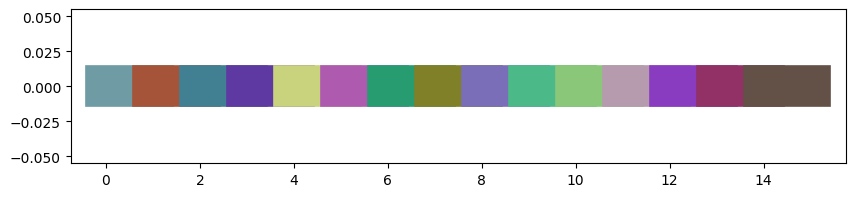

In [84]:
plt.figure(figsize=(10, 2))
# colors = colors[12:15]
# Рисуем каждый цвет в своем квадрате
for i in range(len(colors)):
    plt.plot([i, i+1], [0, 0], color=colors[i], linewidth=30)

plt.show()

## Visualize

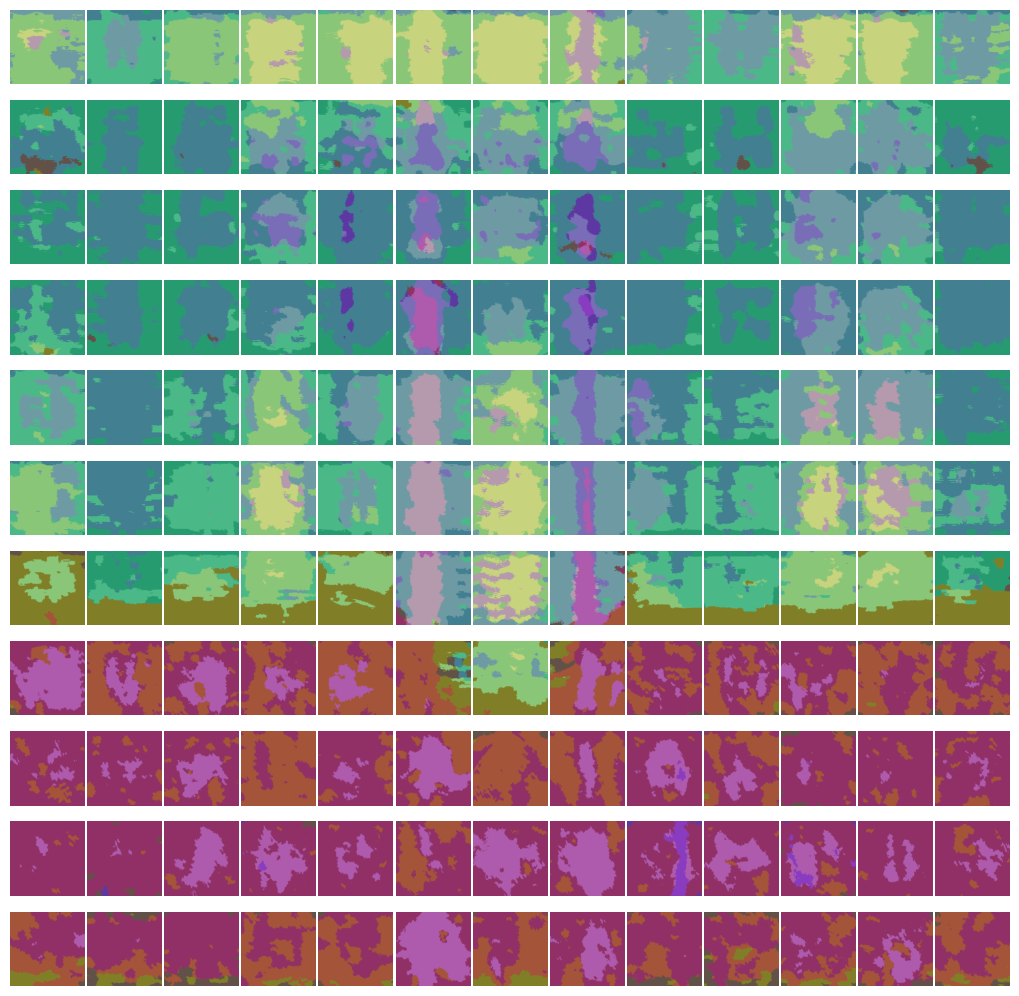

In [85]:
display_image_grid(all_segmented_feats, patches_mat_shape)

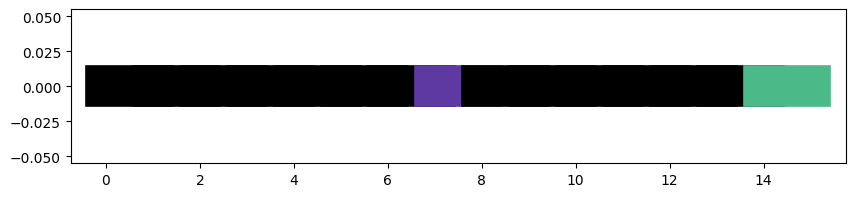

In [86]:
colors2 = kmeans.cluster_centers_.tolist()
for i in range(len(colors2)-1):
    colors2[i] = [0., 0., 0.]
colors2[14] = colors[9]
colors2[7] = colors[3]
plt.figure(figsize=(10, 2))
for i in range(len(colors2)):
    plt.plot([i, i+1], [0, 0], color=colors2[i], linewidth=30)

plt.show()

colors2 = np.array(colors2)

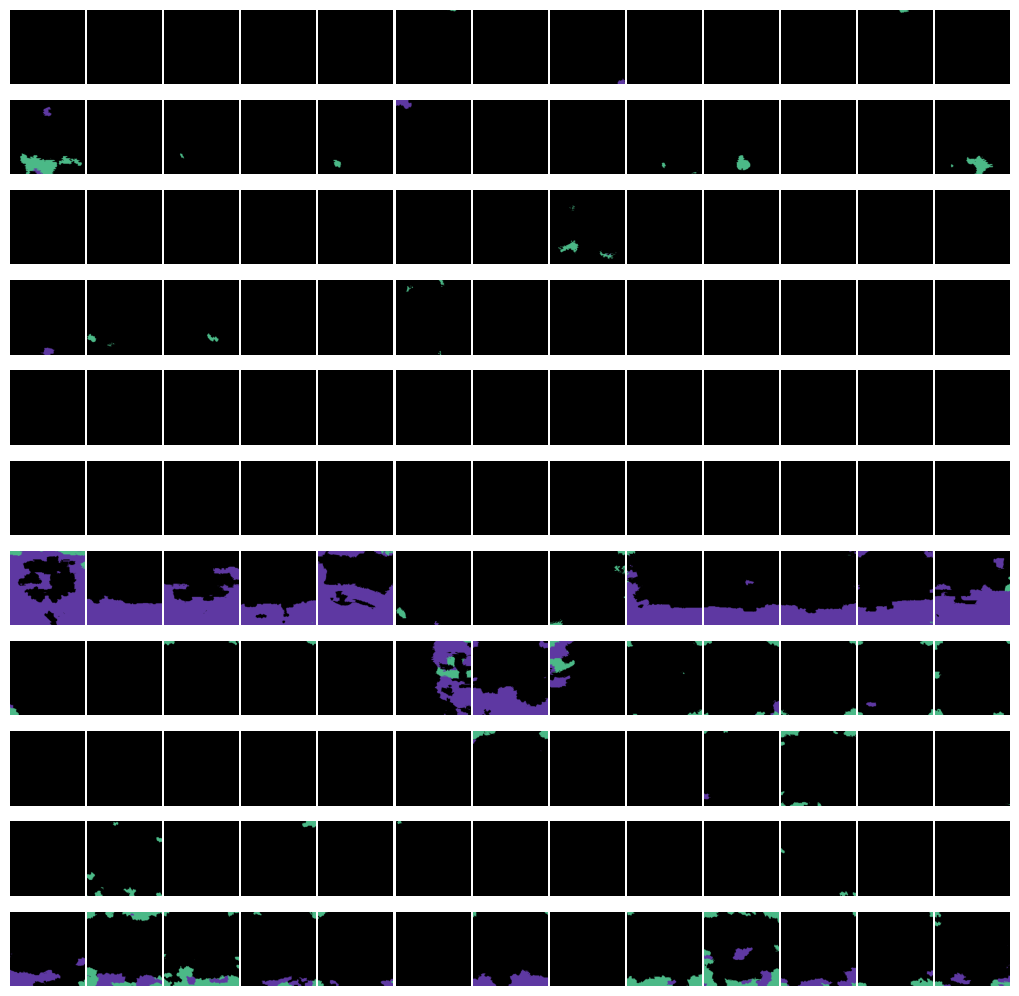

In [87]:
all_segmented_feats = []
for hr_feats in hr_feats_pca_flat:
    segmented_feats = kmeans_predict(kmeans, hr_feats, palette=colors2)
    all_segmented_feats.append(segmented_feats)

display_image_grid(all_segmented_feats, patches_mat_shape)

## Clustering using HDBSCAN

In [54]:
from sklearn.cluster import DBSCAN, HDBSCAN

def hdbscan_color_quantization(pixel_values):
    # Параметры для KMeans
    clusterer = HDBSCAN(min_cluster_size=1000, min_samples=30, n_jobs=60)

    # Применение KMeans
    clusterer.fit(pixel_values)

    # Преобразование центров обратно в uint8
    centers = clusterer.cluster_centers_

    return clusterer, centers


def hdbscan_predict(clusterer, hr_feats, palette = None):
    shape = hr_feats.shape
    feats = hr_feats.reshape((-1, shape[-1]))
    # print(f'{shape=} {feats.shape=}')

    labels = clusterer.predict(feats)
    # print(f'{labels.shape=}')
    centers = clusterer.cluster_centers_
    if palette is not None:
        segmented_image = palette[labels.flatten()]
    else:
        segmented_image = centers[labels.flatten()]
    # print(f'{segmented_image.shape=}')
    segmented_image = segmented_image.reshape((shape[0],shape[1],3))
    return segmented_image

In [55]:

hdbscan_clusterer, centers = hdbscan_color_quantization(all_feats_values, k)

all_segmented_feats = []
for hr_feats in hr_feats_pca_flat:
    segmented_feats = hdbscan_predict(hdbscan_clusterer, hr_feats)
    all_segmented_feats.append(segmented_feats)

## Clustering using original values

In [33]:
hr_feats_list.shape

torch.Size([9, 384, 256, 256])

In [34]:
hr_feats_list_flat = hr_feats_list.permute(0,2,3,1).numpy()
hr_feats_list_flat.shape

(9, 256, 256, 384)

In [35]:
# Combining all 'pixels' into one large dataset


all_feats_values_orig = hr_feats_list_flat.reshape(-1, 384)
all_feats_values_orig.shape

(589824, 384)

In [36]:
# Применение K-means кластеризации ко всему набору данных
k = 20
kmeans2, centers2 = kmeans_color_quantization(all_feats_values_orig, k)

/tmp/ipykernel_28000/3186361605.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


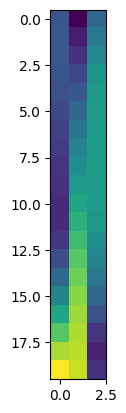

In [37]:
# Создаем colormap
cmap = plt.cm.get_cmap('viridis')

# Получаем палитру размера k
palette = cmap(np.linspace(0, 1, k))
palette = np.delete(palette, 3, axis=1)

plt.imshow(palette)
plt.show()

In [38]:
centers2.shape

(20, 384)

In [39]:
hr_feats_list_flat[0].shape

(256, 256, 384)

In [40]:
all_segmented_feats = []
for hr_feats in hr_feats_list_flat:
    segmented_feats = kmeans_predict(kmeans2, hr_feats, palette=palette)
    all_segmented_feats.append(segmented_feats)

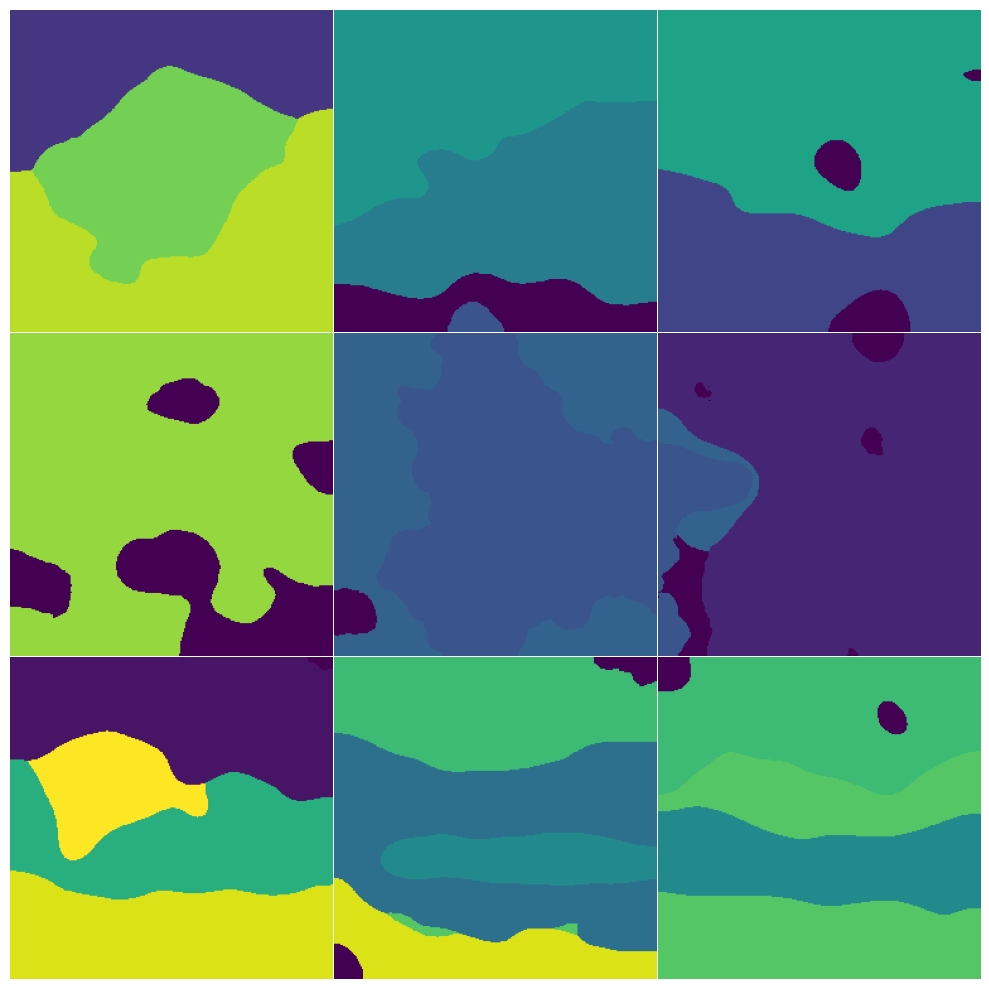

In [41]:
display_image_grid(all_segmented_feats, patches_mat_shape)

# Merge and blend patches

## series 1

In [35]:
def linear_blend_masks(masks, patch_size, overlap):
    num_patches_h, num_patches_w = masks.shape[0], masks.shape[1]
    full_height = num_patches_h * patch_size - (num_patches_h - 1) * overlap
    full_width = num_patches_w * patch_size - (num_patches_w - 1) * overlap
    full_mask = np.zeros((full_height, full_width, masks.shape[-1]), dtype=np.float32)
    weight_mask = np.zeros_like(full_mask)

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            y_start = i * (patch_size - overlap)
            x_start = j * (patch_size - overlap)
            y_end = y_start + patch_size
            x_end = x_start + patch_size

            patch_mask = masks[i, j]
            if i > 0:
                patch_mask[:overlap, :] *= np.linspace(0, 1, overlap*3).reshape(-1, 1, 3)
            if j > 0:
                patch_mask[:, :overlap] *= np.linspace(0, 1, overlap*3).reshape(-1,3)
            if i < num_patches_h - 1:
                patch_mask[-overlap:, :] *= np.linspace(1, 0, overlap*3).reshape(-1, 1, 3)
            if j < num_patches_w - 1:
                patch_mask[:, -overlap:] *= np.linspace(1, 0, overlap*3).reshape(-1,3)

            print(
                f'{full_mask[y_start:y_end, x_start:x_end].shape=} {patch_mask.shape=}')
            full_mask[y_start:y_end, x_start:x_end] += patch_mask
            weight_mask[y_start:y_end, x_start:x_end] += 1

    full_mask /= np.maximum(weight_mask, 1)
    return full_mask


def gaussian_blend_masks(masks, patch_size, overlap):
    num_patches_h, num_patches_w = masks.shape[0], masks.shape[1]
    full_height = num_patches_h * patch_size - (num_patches_h - 1) * overlap
    full_width = num_patches_w * patch_size - (num_patches_w - 1) * overlap
    full_mask = np.zeros((full_height, full_width), dtype=np.float32)
    weight_mask = np.zeros_like(full_mask)

    gaussian_weights = np.outer(cv2.getGaussianKernel(overlap * 2 + 1, 0.3 * ((overlap * 2 + 1) - 1) + 0.8),
                                cv2.getGaussianKernel(overlap * 2 + 1, 0.3 * ((overlap * 2 + 1) - 1) + 0.8))

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            y_start = i * (patch_size - overlap)
            x_start = j * (patch_size - overlap)
            y_end = y_start + patch_size
            x_end = x_start + patch_size

            patch_mask = masks[i, j]
            if i > 0:
                patch_mask[:overlap, :] *= gaussian_weights[overlap:,
                                                            overlap:].reshape(-1, 1)
            if j > 0:
                patch_mask[:, :overlap] *= gaussian_weights[overlap:, overlap:]
            if i < num_patches_h - 1:
                patch_mask[-overlap:, :] *= gaussian_weights[:overlap,
                                                             overlap:].reshape(-1, 1)
            if j < num_patches_w - 1:
                patch_mask[:, -overlap:] *= gaussian_weights[overlap:, :overlap]

            full_mask[y_start:y_end, x_start:x_end] += patch_mask
            weight_mask[y_start:y_end, x_start:x_end] += 1

    full_mask /= np.maximum(weight_mask, 1)
    return full_mask

## series 2

In [36]:
def blend_patches(patches, patch_size, overlap):
    """
    Blend a matrix of overlapping patches into one large image.

    Parameters:
    patches (numpy array): A 4D array of shape (num_patches_y, num_patches_x, patch_size[0], patch_size[1])
    patch_size (tuple): The size of each patch (height, width)
    overlap (int): The number of overlapping pixels between patches

    Returns:
    numpy array: The blended large image
    """
    num_patches_y, num_patches_x = patches.shape[:2]
    patch_height, patch_width = patch_size

    # Calculate the size of the final image
    final_height = num_patches_y * patch_height - (num_patches_y - 1) * overlap
    final_width = num_patches_x * patch_width - (num_patches_x - 1) * overlap

    # Initialize the final image
    final_image = np.zeros(
        (final_height, final_width, patches.shape[2]), dtype=patches.dtype)

    # Initialize the weight mask
    weight_mask = np.zeros((patch_height, patch_width), dtype=np.float32)
    weight_mask[:overlap, :] = np.linspace(0, 1, overlap)
    weight_mask[-overlap:, :] = np.linspace(1, 0, overlap)
    weight_mask[:, :overlap] = np.linspace(0, 1, overlap)[np.newaxis, :]
    weight_mask[:, -overlap:] = np.linspace(1, 0, overlap)[np.newaxis, :]
    weight_mask[overlap:-overlap, overlap:-overlap] = 1

    # Blend the patches into the final image
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = patches[i, j]
            y_start = i * (patch_height - overlap)
            y_end = y_start + patch_height
            x_start = j * (patch_width - overlap)
            x_end = x_start + patch_width

            # Apply the weight mask to the patch
            weighted_patch = patch * weight_mask[..., np.newaxis]

            # Blend the patch into the final image
            final_image[y_start:y_end, x_start:x_end] += weighted_patch

    return final_image

## Series 3

In [37]:
from scipy.interpolate import interp2d


def blend_patches_interpolate(patches, patch_size, overlap):
    """
    Blend a matrix of overlapping patches into one large image using interpolation.

    Parameters:
    patches (numpy array): A 4D array of shape (num_patches_y, num_patches_x, patch_size[0], patch_size[1], channels)
    patch_size (tuple): The size of each patch (height, width)
    overlap (int): The number of overlapping pixels between patches

    Returns:
    numpy array: The blended large image
    """
    num_patches_y, num_patches_x = patches.shape[:2]
    patch_height, patch_width = patch_size
    channels = patches.shape[4]

    # Calculate the size of the final image
    final_height = num_patches_y * patch_height - (num_patches_y - 1) * overlap
    final_width = num_patches_x * patch_width - (num_patches_x - 1) * overlap

    # Initialize the final image
    final_image = np.zeros(
        (final_height, final_width, channels), dtype=patches.dtype)

    # Create a grid for interpolation
    x = np.linspace(0, patch_width - 1, patch_width)
    y = np.linspace(0, patch_height - 1, patch_height)
    xx, yy = np.meshgrid(x, y)

    # Blend the patches into the final image using interpolation
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = patches[i, j]
            y_start = i * (patch_height - overlap)
            y_end = y_start + patch_height
            x_start = j * (patch_width - overlap)
            x_end = x_start + patch_width

            # Create a weight mask for interpolation
            weight_mask = np.ones((patch_height, patch_width))
            if i > 0:
                weight_mask[:overlap,
                            :] *= np.linspace(0, 1, overlap)[:, np.newaxis]
            if i < num_patches_y - 1:
                weight_mask[-overlap:,
                            :] *= np.linspace(1, 0, overlap)[:, np.newaxis]
            if j > 0:
                weight_mask[:,
                            :overlap] *= np.linspace(0, 1, overlap)[np.newaxis, :]
            if j < num_patches_x - 1:
                weight_mask[:, -
                            overlap:] *= np.linspace(1, 0, overlap)[np.newaxis, :]

            # Apply the weight mask to the patch
            weighted_patch = patch * weight_mask[..., np.newaxis]

            # Interpolate the patch
            for c in range(channels):
                interpolator = interp2d(
                    xx, yy, weighted_patch[..., c], kind='linear')
                final_image[y_start:y_end, x_start:x_end,
                            c] += interpolator(x, y)

    return final_image

## Series 4

In [75]:
import numpy as np
# from skimage.util import view_as_windows


def blend_patches_g(patches, patch_size, overlap, blend_func=np.mean):
  """Blends overlapping patches into a single image.

  Args:
    patches: A numpy array of shape (num_patches, patch_size, patch_size, channels).
    patch_size: The size of each patch.
    overlap: The overlap between adjacent patches.
    blend_func: The blending function to use (default: np.mean).

  Returns:
    The blended image as a numpy array.
  """

  cols, rows, _, _, channels = patches.shape
  patch_step = patch_size - overlap

  # Calculate output image dimensions
  output_size = (rows * patch_step + overlap)

  # Create empty output image
  output_image = np.zeros(
      (output_size, output_size, channels), dtype=patches.dtype)

  # Iterate through patches
  for i in range(cols):
    for j in range(rows):
      patch = patches[i, j]
      start_x = i * patch_step
      end_x = start_x + patch_size
      start_y = j * patch_step
      end_y = start_y + patch_size

      # Calculate overlap region
      overlap_x = min(end_x, output_size) - max(start_x, 0)
      overlap_y = min(end_y, output_size) - max(start_y, 0)

      # Apply blending function
      output_image[start_x:end_x, start_y:end_y] = blend_func(
          (output_image[start_x:end_x, start_y:end_y],
           patch[:overlap_x, :overlap_y]),
          axis=0
      )

  return output_image

In [72]:
from scipy.interpolate import RectBivariateSpline


def smooth_blend_patches_intp(patches, patch_size, overlap):
  """Smoothly blends overlapping patches into a single image using 2D interpolation.

  Args:
    patches: A numpy array of shape (num_patches, patch_size, patch_size, channels).
    patch_size: The size of each patch.
    overlap: The overlap between adjacent patches.

  Returns:
    The blended image as a numpy array.
  """

  # num_patches, _, _, channels = patches.shape
  cols, rows, _, _, channels = patches.shape
  num_patches = cols * rows
  patch_step = patch_size - overlap

  # Calculate output image dimensions
  output_size = (num_patches * patch_step + overlap)

  # Create empty output image
  output_image = np.zeros(
      (output_size, output_size, channels), dtype=patches.dtype)

  # Iterate through patches
  for i in range(cols):
    for j in range(rows):
      patch = patches[i, j]
      start_x = i * patch_step
      end_x = start_x + patch_size
      start_y = j * patch_step
      end_y = start_y + patch_size

      # Calculate overlap region
      overlap_x = min(end_x, output_size) - max(start_x, 0)
      overlap_y = min(end_y, output_size) - max(start_y, 0)

      # Create interpolation function
      interp_func = RectBivariateSpline(
          np.arange(patch_size), np.arange(patch_size), patch)

      # Generate coordinates for interpolation
      x = np.arange(start_x, min(end_x, output_size))
      y = np.arange(start_y, min(end_y, output_size))
      X, Y = np.meshgrid(x, y)

      # Interpolate patch values onto output image
      output_image[start_x:end_x, start_y:end_y] += interp_func(X, Y)

  return output_image

## Blend

In [76]:
print(f'{hr_feats_mat.shape=}')
# m = linear_blend_masks(hr_feats_mat, 256, output_overlap)

m = blend_patches_g(hr_feats_mat,  256, output_overlap)
# m = smooth_blend_patches_intp(hr_feats_mat, 256, output_overlap)

hr_feats_mat.shape=(5, 7, 256, 256, 3)


In [40]:
m.shape

(1024, 1408, 3)

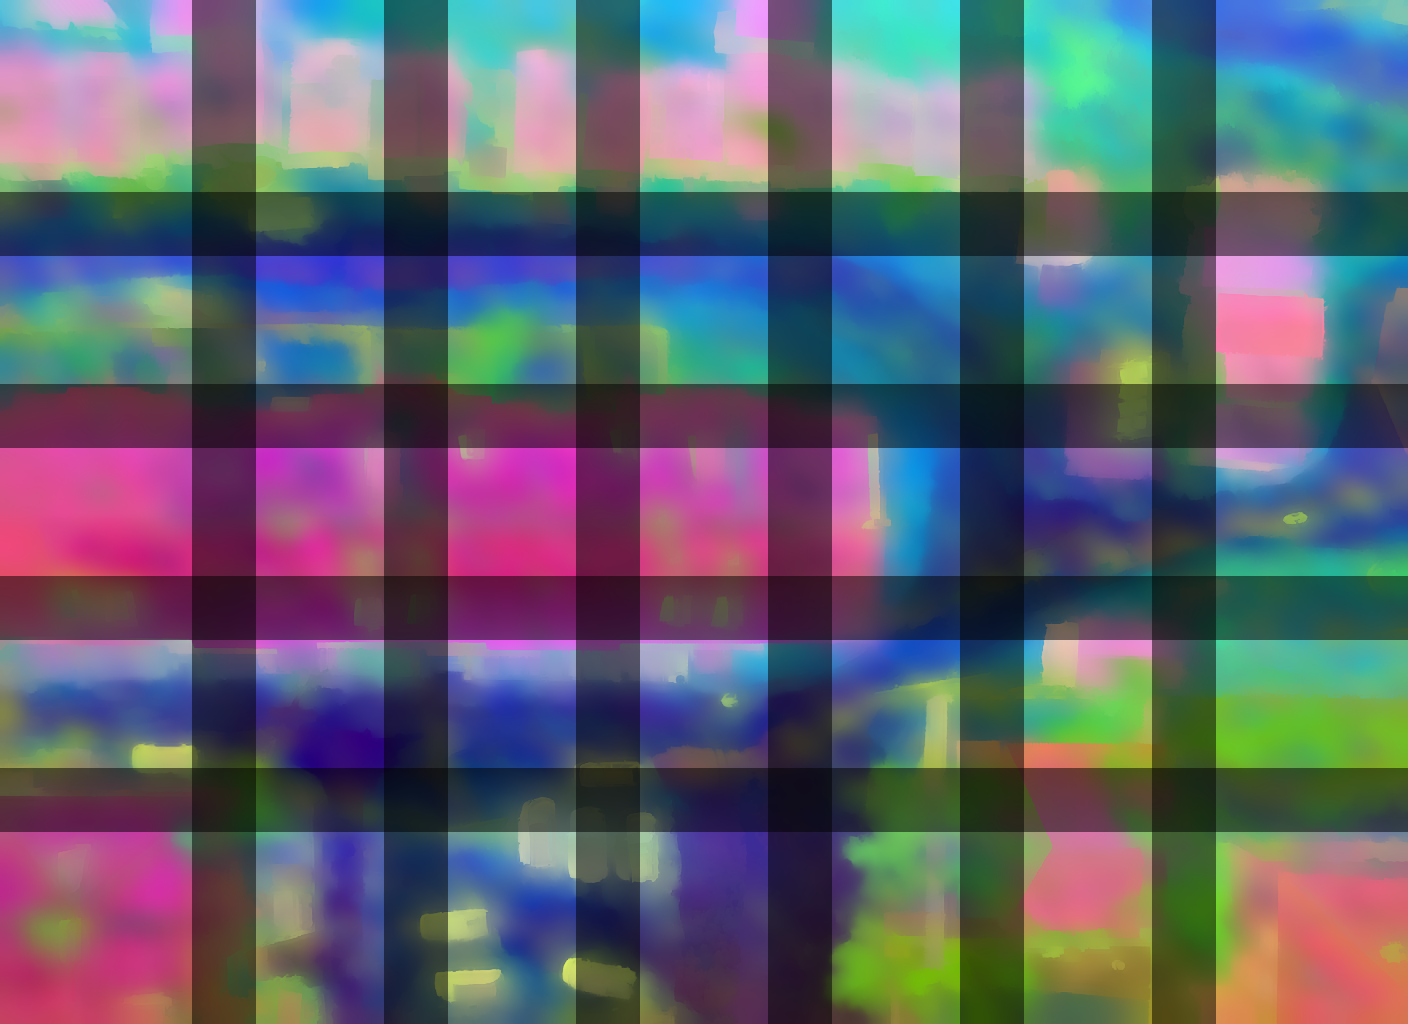

In [41]:
import matplotlib.pyplot as plt


rim = Image.fromarray((m*255).astype(np.uint8))

# fig, ax = plt.subplots(figsize=(10, 10))  
# ax.imshow(m)
# ax.set_axis_off()
# # plt.colorbar()
# plt.show()
rim